In [1]:
TRAIN_PATH = 'documents_functions_data/document_function_train.csv'
TEST_PATH = 'documents_functions_data/document_function_test.csv'

In [2]:
import pandas as pd
import plotly.express as px
import spacy
import plotly.express as px
from sklearn.metrics import accuracy_score
from sklearn import metrics
from sklearn.metrics import plot_confusion_matrix, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from flair.models import TARSClassifier
from flair.data import Sentence
from flair.datasets import SentenceDataset
from flair.trainers import ModelTrainer
from flair.data import Corpus
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt


In [3]:
df = pd.read_csv(TRAIN_PATH)
df_test = pd.read_csv(TEST_PATH)
df_full = pd.concat([df, df_test], ignore_index=True)

d = {
'strategy': "strategy, document describing actions that should be taken towards AI",
 'body or organization':"document establishing AI-related body or organization",
 'diagnosis': "diagnosis, report, or other document describing the current state of AI",
 'principles': "principles, sets of ethical rules regarding AI",
 'regulation': "legal regulation addressing AI",
 'pre-regulation': "proposal of legal regulation addressing AI"
}
df['docFunctionLong']= df['documentFunction'].map(d)
df_test['docFunctionLong']= df_test['documentFunction'].map(d)
df_full['docFunctionLong']= df_full['documentFunction'].map(d)

X_train = df.title
y_train = df.documentFunction
y_train_long = df.docFunctionLong

X_test = df_test.title
y_test = df_test.documentFunction
y_test_long = df_test.docFunctionLong

X_full = df_full.title
y_full = df_full.documentFunction
y_full_long = df_full.docFunctionLong

In [4]:
px.histogram(y_train)

In [5]:
px.histogram(y_test)

In [43]:
df_=df[['title', 'documentFunction']]

pd.concat([df_.query('documentFunction=="strategy"').head(3),
df_.query('documentFunction=="body or organization"').head(3),
df_.query('documentFunction=="diagnosis"').head(3),
df_.query('documentFunction=="principles"').head(3),
df_.query('documentFunction=="regulation"').head(3),
df_.query('documentFunction=="pre-regulation"').head(3)])



,title,documentFunction
1,AI FOR INDUSTRY,strategy
2,AI SINGAPORE,strategy
3,WELSH LANGUAGE TECHNOLOGY ACTION PLAN,strategy
0,MATERIALS GENOME INITIATIVE,body or organization
5,KNOWLEDGE CENTRE FOR DATA AND SOCIETY,body or organization
6,ARTIFICIAL INTELLIGENCE AND TECHNOLOGY OFFICE,body or organization
31,AI BAROMETER,diagnosis
38,AI GRAND CHALLENGES,diagnosis
56,CIVIL LIABILITY REGIME FOR ARTIFICIAL INTELLIG...,diagnosis
18,AI ETHICS AND GOVERNANCE BODY OF KNOWLEDGE,principles


## Baseline: argmax

In [7]:
print("TRAIN:",accuracy_score(df.documentFunction, ['strategy']*len(df)))
print("TEST:",accuracy_score(df_test.documentFunction, ['strategy']*len(df_test)))

TRAIN: 0.4189723320158103
TEST: 0.4117647058823529


## Baseline: logistic regression on BoW

In [8]:
def prep_lemmas(df):
    lemmas = df.title.apply(nlp).apply(lambda d: [(t.lemma_).lower() for t in d if not t.is_stop])
    lemmas_joined = lemmas.apply(lambda t: ' '.join(t))
    return lemmas_joined

nlp = spacy.load('en_core_web_sm')
X = prep_lemmas(df)
classifier = LogisticRegression(penalty="l2", multi_class="multinomial")

pipeline = Pipeline(
    [
        ("preprocessing", CountVectorizer()),
        ("classifier", LogisticRegression(penalty="l2", multi_class="multinomial")),
    ]
)

pipeline = pipeline.fit(X, df.documentFunction)

#### Train acc

In [9]:
y_pred = pipeline.predict(X)
accuracy_score(y_train, y_pred)

0.9881422924901185

#### Test acc

In [10]:
X = prep_lemmas(df_test)

y_pred = pipeline.predict(X)
accuracy_score(y_test, y_pred)

0.7176470588235294

# TARS: zero shot

In [11]:
tars = TARSClassifier.load('tars-base')
def predict_zero_shot(titles, classes):
    prepared = titles.apply(Sentence)
    for title in prepared:
        tars.predict_zero_shot(title, classes, multi_label=False)
    return prepared
    
def get_predictions(sentences: pd.Series):
    labels = sentences.apply(lambda s: sorted(s.labels, key=lambda l: l.score, reverse=True)[0].value)
    scores = sentences.apply(lambda s: sorted(s.labels, key=lambda l: l.score, reverse=True)[0].score)
    
    return labels, scores

2021-11-05 01:05:10,118 loading file /home/stanislaw/.flair/models/tars-base-v8.pt
{'TREC_6': {'label_dictionary': <flair.data.Dictionary object at 0x7fabe5b08370>, 'multi_label': False, 'multi_label_threshold': 0.5, 'label_type': None, 'beta': 1.0}, 'DBPedia': {'label_dictionary': <flair.data.Dictionary object at 0x7fabe5b08070>, 'multi_label': False, 'multi_label_threshold': 0.5, 'label_type': None, 'beta': 1.0}, 'AGNews': {'label_dictionary': <flair.data.Dictionary object at 0x7fabe5b08850>, 'multi_label': False, 'multi_label_threshold': 0.5, 'label_type': None, 'beta': 1.0}, 'IMDB': {'label_dictionary': <flair.data.Dictionary object at 0x7fabe5b088b0>, 'multi_label': False, 'multi_label_threshold': 0.5, 'label_type': None, 'beta': 1.0}, 'SST': {'label_dictionary': <flair.data.Dictionary object at 0x7fabe5b08d00>, 'multi_label': False, 'multi_label_threshold': 0.5, 'label_type': None, 'beta': 1.0}, 'GO_EMOTIONS': {'label_dictionary': <flair.data.Dictionary object at 0x7fabe5b08310>,

In [12]:
classes = list(df_test.documentFunction.drop_duplicates())
classes_long = list(df_test.docFunctionLong.drop_duplicates())
classes_long,classes

(['strategy, document describing actions that should be taken towards AI',
  'document establishing AI-related body or organization',
  'diagnosis, report, or other document describing the current state of AI',
  'principles, sets of ethical rules regarding AI',
  'legal regulation addressing AI',
  'proposal of legal regulation addressing AI'],
 ['strategy',
  'body or organization',
  'diagnosis',
  'principles',
  'regulation',
  'pre-regulation'])

## Zero shot: short labels

In [13]:
titles = predict_zero_shot(X_test, classes)
pred, scores = get_predictions(titles)
acc = accuracy_score(y_test, pred)

In [14]:
print(acc)

0.4823529411764706


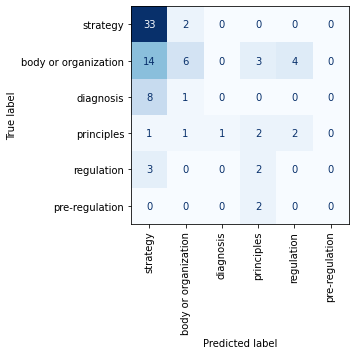

In [15]:
ConfusionMatrixDisplay(
    confusion_matrix(y_test, pred, labels=classes), display_labels=classes
).plot(xticks_rotation="vertical", cmap=plt.cm.Blues, colorbar=False)
plt.show()


## Zero-shot with longer labels

In [16]:
titles = predict_zero_shot(X_test, y_test_long)
pred_2, scores_2 = get_predictions(titles)
accuracy_score(y_test_long, pred_2)

0.38823529411764707

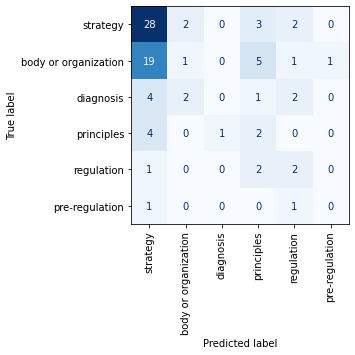

In [17]:
ConfusionMatrixDisplay(
    confusion_matrix(y_test_long, pred_2, labels=classes_long), display_labels=classes
).plot(xticks_rotation="vertical", cmap=plt.cm.Blues, colorbar=False)
plt.show()

In [18]:
titles = predict_zero_shot(X_full, y_full)
pred, scores = get_predictions(titles)


titles = predict_zero_shot(X_full, y_full_long)
pred_long, scores_long = get_predictions(titles)


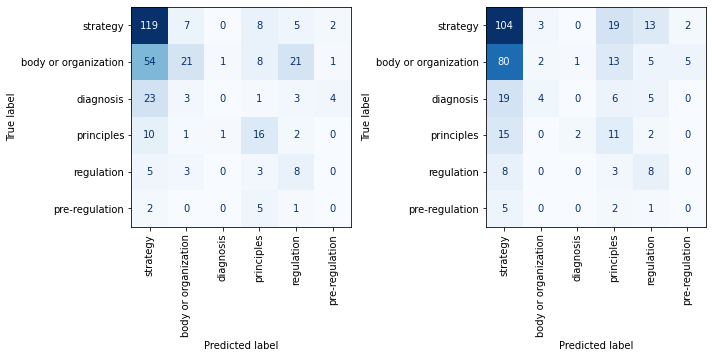

In [19]:
from matplotlib.pyplot import figure

fig, ax = plt.subplots(1,2,figsize=(10, 8))
ConfusionMatrixDisplay(
    confusion_matrix(y_full, pred, labels=classes), display_labels=classes
).plot(xticks_rotation="vertical", cmap=plt.cm.Blues, colorbar=False,ax=ax[0])
# ax = plt.subplot(122)
ConfusionMatrixDisplay(
    confusion_matrix(y_full_long, pred_long, labels=classes_long), display_labels=classes
).plot(xticks_rotation="vertical", cmap=plt.cm.Blues, colorbar=False,ax=ax[1])
plt.tight_layout()

plt.savefig('confusion_matrix.pdf')#, dpi=200)

## TARS: few shot

In [20]:
def create_set(sentences: list, labels: list, label_name: str):
    dataset = SentenceDataset(
        [
            Sentence(sent).add_label(label_name, label)
            for sent, label in zip(sentences, labels)
        ]
    )
    
    return dataset


def train_and_get_model(X_train, y_train, X_test, y_test,model_name):
    tars = TARSClassifier.load('tars-base')

    train_set = create_set(X_train, y_train, "Document function")
    test_set = create_set(X_test, y_test, "Document function")
    corpus = Corpus(train=train_set)
    label_type = 'Document function'
    label_dict = corpus.make_label_dictionary(label_type=label_type)

    tars.add_and_switch_to_new_task("Document function classification",label_dictionary=label_dict,label_type=label_type)
    trainer = ModelTrainer(tars, corpus)
    trainer.train(base_path=f'models/{model_name}', # path to store the model artifacts
                learning_rate=0.02, # use very small learning rate
                mini_batch_size=16, # small mini-batch size since corpus is tiny
                max_epochs=10, # terminate after 10 epochs
                train_with_dev=True,
                )

    trained = TARSClassifier.load(f'models/{model_name}/final-model.pt')
    return trained

In [21]:
trained_base = train_and_get_model(X_train, y_train, X_test, y_test, "base")


test_sents = X_test.apply(Sentence)
trained_base.predict(list(test_sents))
pred, scores = get_predictions(test_sents)
acc = accuracy_score(y_test, pred)

2021-11-05 01:05:50,815 loading file /home/stanislaw/.flair/models/tars-base-v8.pt
{'TREC_6': {'label_dictionary': <flair.data.Dictionary object at 0x7fabdc845460>, 'multi_label': False, 'multi_label_threshold': 0.5, 'label_type': None, 'beta': 1.0}, 'DBPedia': {'label_dictionary': <flair.data.Dictionary object at 0x7fabdc845490>, 'multi_label': False, 'multi_label_threshold': 0.5, 'label_type': None, 'beta': 1.0}, 'AGNews': {'label_dictionary': <flair.data.Dictionary object at 0x7fabdc845700>, 'multi_label': False, 'multi_label_threshold': 0.5, 'label_type': None, 'beta': 1.0}, 'IMDB': {'label_dictionary': <flair.data.Dictionary object at 0x7fabdc8457c0>, 'multi_label': False, 'multi_label_threshold': 0.5, 'label_type': None, 'beta': 1.0}, 'SST': {'label_dictionary': <flair.data.Dictionary object at 0x7fabdc845820>, 'multi_label': False, 'multi_label_threshold': 0.5, 'label_type': None, 'beta': 1.0}, 'GO_EMOTIONS': {'label_dictionary': <flair.data.Dictionary object at 0x7fabdc845880>,

100%|██████████| 205/205 [00:00<00:00, 36921.69it/s]

2021-11-05 01:05:55,927 Corpus contains the labels: Document function (#205)
2021-11-05 01:05:55,927 Created (for label 'Document function') Dictionary with 6 tags: body or organization, strategy, regulation, principles, diagnosis, pre-regulation
2021-11-05 01:05:55,928 ----------------------------------------------------------------------------------------------------
2021-11-05 01:05:55,930 Model: "TARSClassifier(
  (tars_model): TextClassifier(
    (loss_function): CrossEntropyLoss()
    (document_embeddings): TransformerDocumentEmbeddings(
      (model): BertModel(
        (embeddings): BertEmbeddings(
          (word_embeddings): Embedding(30522, 768, padding_idx=0)
          (position_embeddings): Embedding(512, 768)
          (token_type_embeddings): Embedding(2, 768)
          (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (dropout): Dropout(p=0.1, inplace=False)
        )
        (encoder): BertEncoder(
          (layer): ModuleList(
            (

2021-11-05 01:05:56,230 epoch 1 - iter 2/15 - loss 0.01829961 - samples/sec: 97.92 - lr: 0.020000
2021-11-05 01:05:56,341 epoch 1 - iter 3/15 - loss 0.01661840 - samples/sec: 145.11 - lr: 0.020000
2021-11-05 01:05:56,463 epoch 1 - iter 4/15 - loss 0.01588357 - samples/sec: 132.50 - lr: 0.020000
2021-11-05 01:05:56,577 epoch 1 - iter 5/15 - loss 0.01476383 - samples/sec: 141.42 - lr: 0.020000
2021-11-05 01:05:56,712 epoch 1 - iter 6/15 - loss 0.01463976 - samples/sec: 118.62 - lr: 0.020000
2021-11-05 01:05:56,830 epoch 1 - iter 7/15 - loss 0.01370380 - samples/sec: 137.40 - lr: 0.020000
2021-11-05 01:05:56,936 epoch 1 - iter 8/15 - loss 0.01312879 - samples/sec: 151.75 - lr: 0.020000
2021-11-05 01:05:57,038 epoch 1 - iter 9/15 - loss 0.01301665 - samples/sec: 158.29 - lr: 0.020000
2021-11-05 01:05:57,144 epoch 1 - iter 10/15 - loss 0.01254864 - samples/sec: 151.76 - lr: 0.020000
2021-11-05 01:05:57,289 epoch 1 - iter 11/15 - loss 0.01257931 - samples/sec: 110.92 - lr: 0.020000
2021-11-0

In [22]:
print("TEST ACC:",acc)

TEST ACC: 0.8705882352941177


In [29]:
def get_probs(sents):
    all_probs=[]

    for s in sents:
        probs = dict()
        for l in s.labels:
            probs[l.value]=l.score
        all_probs.append(probs)
    return pd.DataFrame(all_probs)

/home/stanislaw/repos/TARSPolicyClassification/.venv/lib/python3.8/site-packages/sklearn/metrics/_ranking.py:999: UndefinedMetricWarning:

No positive samples in y_true, true positive value should be meaningless

/home/stanislaw/repos/TARSPolicyClassification/.venv/lib/python3.8/site-packages/sklearn/metrics/_ranking.py:999: UndefinedMetricWarning:

No positive samples in y_true, true positive value should be meaningless

/home/stanislaw/repos/TARSPolicyClassification/.venv/lib/python3.8/site-packages/sklearn/metrics/_ranking.py:999: UndefinedMetricWarning:

No positive samples in y_true, true positive value should be meaningless

/home/stanislaw/repos/TARSPolicyClassification/.venv/lib/python3.8/site-packages/sklearn/metrics/_ranking.py:999: UndefinedMetricWarning:

No positive samples in y_true, true positive value should be meaningless

/home/stanislaw/repos/TARSPolicyClassification/.venv/lib/python3.8/site-packages/sklearn/metrics/_ranking.py:999: UndefinedMetricWarning:

No positi

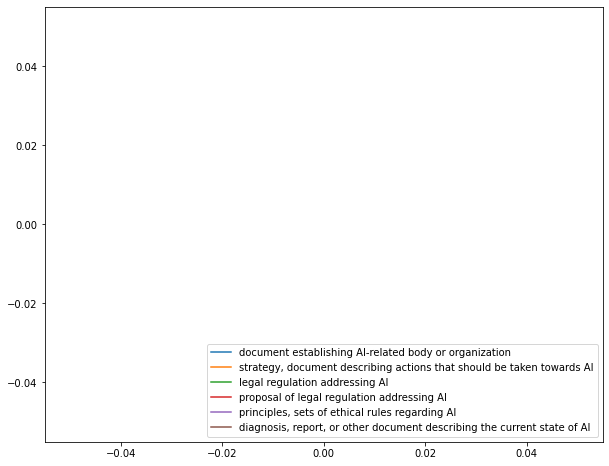

In [30]:
probs = get_probs(test_sents)
figure(figsize=(10, 8))
for label in probs.columns:
    fpr, tpr, _ = metrics.roc_curve(y_test==label, probs[label])
    plt.plot(fpr,tpr,label=label)
plt.legend(loc=4)
plt.show()

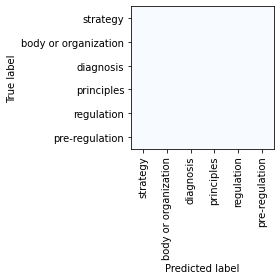

In [31]:
labels = y_test.unique()
ConfusionMatrixDisplay(
    confusion_matrix(y_test, pred, labels=labels), display_labels=labels
).plot(xticks_rotation="vertical", cmap=plt.cm.Blues, colorbar=False)
plt.tight_layout()
plt.savefig('confusion_matrix.pdf')#, dpi=200)

# Long labels

In [26]:
trained_long = train_and_get_model(X_train, y_train_long, X_test, y_test_long, "few-shot-long")


test_sents = X_test.apply(Sentence)
trained_long.predict(list(test_sents))
pred, scores = get_predictions(test_sents)
acc = accuracy_score(y_test_long, pred)

2021-11-05 01:06:22,292 loading file /home/stanislaw/.flair/models/tars-base-v8.pt
{'TREC_6': {'label_dictionary': <flair.data.Dictionary object at 0x7fabd14b3d30>, 'multi_label': False, 'multi_label_threshold': 0.5, 'label_type': None, 'beta': 1.0}, 'DBPedia': {'label_dictionary': <flair.data.Dictionary object at 0x7fabd14b3d60>, 'multi_label': False, 'multi_label_threshold': 0.5, 'label_type': None, 'beta': 1.0}, 'AGNews': {'label_dictionary': <flair.data.Dictionary object at 0x7fabe21da280>, 'multi_label': False, 'multi_label_threshold': 0.5, 'label_type': None, 'beta': 1.0}, 'IMDB': {'label_dictionary': <flair.data.Dictionary object at 0x7fabe21da100>, 'multi_label': False, 'multi_label_threshold': 0.5, 'label_type': None, 'beta': 1.0}, 'SST': {'label_dictionary': <flair.data.Dictionary object at 0x7fabe21dafa0>, 'multi_label': False, 'multi_label_threshold': 0.5, 'label_type': None, 'beta': 1.0}, 'GO_EMOTIONS': {'label_dictionary': <flair.data.Dictionary object at 0x7fabe21da0d0>,

100%|██████████| 205/205 [00:00<00:00, 40038.76it/s]

2021-11-05 01:06:27,184 Corpus contains the labels: Document function (#205)
2021-11-05 01:06:27,185 Created (for label 'Document function') Dictionary with 6 tags: document establishing AI-related body or organization, strategy, document describing actions that should be taken towards AI, legal regulation addressing AI, proposal of legal regulation addressing AI, principles, sets of ethical rules regarding AI, diagnosis, report, or other document describing the current state of AI
2021-11-05 01:06:27,186 ----------------------------------------------------------------------------------------------------
2021-11-05 01:06:27,187 Model: "TARSClassifier(
  (tars_model): TextClassifier(
    (loss_function): CrossEntropyLoss()
    (document_embeddings): TransformerDocumentEmbeddings(
      (model): BertModel(
        (embeddings): BertEmbeddings(
          (word_embeddings): Embedding(30522, 768, padding_idx=0)
          (position_embeddings): Embedding(512, 768)
          (token_type_embed

2021-11-05 01:06:27,476 epoch 1 - iter 2/15 - loss 0.02253569 - samples/sec: 116.90 - lr: 0.020000
2021-11-05 01:06:27,600 epoch 1 - iter 3/15 - loss 0.02008842 - samples/sec: 129.68 - lr: 0.020000
2021-11-05 01:06:27,710 epoch 1 - iter 4/15 - loss 0.01847633 - samples/sec: 146.38 - lr: 0.020000
2021-11-05 01:06:27,820 epoch 1 - iter 5/15 - loss 0.01837939 - samples/sec: 145.87 - lr: 0.020000
2021-11-05 01:06:27,987 epoch 1 - iter 6/15 - loss 0.01749854 - samples/sec: 96.72 - lr: 0.020000
2021-11-05 01:06:28,171 epoch 1 - iter 7/15 - loss 0.01670260 - samples/sec: 87.04 - lr: 0.020000
2021-11-05 01:06:28,313 epoch 1 - iter 8/15 - loss 0.01586158 - samples/sec: 113.25 - lr: 0.020000
2021-11-05 01:06:28,465 epoch 1 - iter 9/15 - loss 0.01559946 - samples/sec: 106.42 - lr: 0.020000
2021-11-05 01:06:28,616 epoch 1 - iter 10/15 - loss 0.01512423 - samples/sec: 106.05 - lr: 0.020000
2021-11-05 01:06:28,815 epoch 1 - iter 11/15 - loss 0.01467232 - samples/sec: 80.91 - lr: 0.020000
2021-11-05 

In [27]:
print(acc)

0.8705882352941177


## Smaller Training set

In [28]:
import sklearn.model_selection
train, test = sklearn.model_selection.train_test_split(df_full, test_size=.5, stratify = df_full.documentFunction)

In [223]:
trained_small = train_and_get_model(train.title, train.documentFunction, test.title, test.documentFunction, "few-shot-smaller-set")

2021-11-05 00:59:29,824 loading file /home/stanislaw/.flair/models/tars-base-v8.pt
{'TREC_6': {'label_dictionary': <flair.data.Dictionary object at 0x7f31b06e9940>, 'multi_label': False, 'multi_label_threshold': 0.5, 'label_type': None, 'beta': 1.0}, 'DBPedia': {'label_dictionary': <flair.data.Dictionary object at 0x7f31b02abfd0>, 'multi_label': False, 'multi_label_threshold': 0.5, 'label_type': None, 'beta': 1.0}, 'AGNews': {'label_dictionary': <flair.data.Dictionary object at 0x7f31b0510b20>, 'multi_label': False, 'multi_label_threshold': 0.5, 'label_type': None, 'beta': 1.0}, 'IMDB': {'label_dictionary': <flair.data.Dictionary object at 0x7f31b05106d0>, 'multi_label': False, 'multi_label_threshold': 0.5, 'label_type': None, 'beta': 1.0}, 'SST': {'label_dictionary': <flair.data.Dictionary object at 0x7f31b0510970>, 'multi_label': False, 'multi_label_threshold': 0.5, 'label_type': None, 'beta': 1.0}, 'GO_EMOTIONS': {'label_dictionary': <flair.data.Dictionary object at 0x7f31b0510e50>,

100%|██████████| 152/152 [00:00<00:00, 38596.33it/s]

2021-11-05 00:59:34,827 Corpus contains the labels: Document function (#152)
2021-11-05 00:59:34,827 Created (for label 'Document function') Dictionary with 6 tags: strategy, regulation, principles, diagnosis, body or organization, pre-regulation
2021-11-05 00:59:34,828 ----------------------------------------------------------------------------------------------------
2021-11-05 00:59:34,830 Model: "TARSClassifier(
  (tars_model): TextClassifier(
    (loss_function): CrossEntropyLoss()
    (document_embeddings): TransformerDocumentEmbeddings(
      (model): BertModel(
        (embeddings): BertEmbeddings(
          (word_embeddings): Embedding(30522, 768, padding_idx=0)
          (position_embeddings): Embedding(512, 768)
          (token_type_embeddings): Embedding(2, 768)
          (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (dropout): Dropout(p=0.1, inplace=False)
        )
        (encoder): BertEncoder(
          (layer): ModuleList(
            (

2021-11-05 00:59:35,064 epoch 1 - iter 2/11 - loss 0.01877687 - samples/sec: 145.26 - lr: 0.020000
2021-11-05 00:59:35,217 epoch 1 - iter 3/11 - loss 0.01596526 - samples/sec: 105.16 - lr: 0.020000
2021-11-05 00:59:35,309 epoch 1 - iter 4/11 - loss 0.01566565 - samples/sec: 174.66 - lr: 0.020000
2021-11-05 00:59:35,416 epoch 1 - iter 5/11 - loss 0.01429666 - samples/sec: 150.69 - lr: 0.020000
2021-11-05 00:59:35,510 epoch 1 - iter 6/11 - loss 0.01496256 - samples/sec: 170.94 - lr: 0.020000
2021-11-05 00:59:35,634 epoch 1 - iter 7/11 - loss 0.01461281 - samples/sec: 129.97 - lr: 0.020000
2021-11-05 00:59:35,741 epoch 1 - iter 8/11 - loss 0.01395825 - samples/sec: 149.32 - lr: 0.020000
2021-11-05 00:59:35,831 epoch 1 - iter 9/11 - loss 0.01357035 - samples/sec: 179.77 - lr: 0.020000
2021-11-05 00:59:35,948 epoch 1 - iter 10/11 - loss 0.01312395 - samples/sec: 137.57 - lr: 0.020000
2021-11-05 00:59:36,027 epoch 1 - iter 11/11 - loss 0.01328158 - samples/sec: 203.91 - lr: 0.020000
2021-11-

In [224]:
test_sents = test.title.apply(Sentence)
trained_small.predict(list(test_sents))
pred, scores = get_predictions(test_sents)
acc = accuracy_score(test.documentFunction, pred)


In [225]:
acc

0.834319526627219

## bert Baseline

In [95]:
from transformers import AutoTokenizer
from transformers import AutoModelForSequenceClassification

tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased")
model = AutoModelForSequenceClassification.from_pretrained("distilbert-base-uncased", num_labels=6)


loading configuration file https://huggingface.co/distilbert-base-uncased/resolve/main/config.json from cache at /home/stanislaw/.cache/huggingface/transformers/23454919702d26495337f3da04d1655c7ee010d5ec9d77bdb9e399e00302c0a1.91b885ab15d631bf9cee9dc9d25ece0afd932f2f5130eba28f2055b2220c0333
Model config DistilBertConfig {
  "activation": "gelu",
  "architectures": [
    "DistilBertForMaskedLM"
  ],
  "attention_dropout": 0.1,
  "dim": 768,
  "dropout": 0.1,
  "hidden_dim": 3072,
  "initializer_range": 0.02,
  "max_position_embeddings": 512,
  "model_type": "distilbert",
  "n_heads": 12,
  "n_layers": 6,
  "pad_token_id": 0,
  "qa_dropout": 0.1,
  "seq_classif_dropout": 0.2,
  "sinusoidal_pos_embds": false,
  "tie_weights_": true,
  "transformers_version": "4.12.3",
  "vocab_size": 30522
}

loading file https://huggingface.co/distilbert-base-uncased/resolve/main/vocab.txt from cache at /home/stanislaw/.cache/huggingface/transformers/0e1bbfda7f63a99bb52e3915dcf10c3c92122b827d92eb2d34ce94e

In [96]:
from datasets import Dataset


In [97]:
func_to_label={'body or organization': 0,
 'strategy': 1,
 'regulation': 2,
 'pre-regulation': 3,
 'principles': 4,
 'diagnosis': 5}

In [98]:
train = Dataset.from_pandas(df)
test = Dataset.from_pandas(df_test)

# train = train.rename_column('documentFunction', 'label')
# test = test.rename_column('documentFunction', 'label')

In [99]:
train = train.map(lambda a: {'label':func_to_label[a['documentFunction']]})
test = test.map(lambda a: {'label':func_to_label[a['documentFunction']]})
train = train.remove_columns(['oecdId','docFunctionLong','documentFunction'])
test = test.remove_columns(['oecdId','docFunctionLong','documentFunction'])

train = train.map(lambda e: tokenizer(e['title'], truncation=True, padding='max_length'), batched=True)
test = test.map(lambda e: tokenizer(e['title'], truncation=True, padding='max_length'), batched=True)


100%|██████████| 1/1 [00:00<00:00, 124.19ba/s]


In [100]:
train

Dataset({
    features: ['attention_mask', 'input_ids', 'label', 'title'],
    num_rows: 253
})

In [104]:
from transformers import TrainingArguments,Trainer

training_args = TrainingArguments("destill_bert",num_train_epochs=10,)


PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).


In [126]:
trainer = Trainer(
    model=model, args=training_args, train_dataset=train, eval_dataset=test,compute_metrics=compute_metrics
)


In [106]:
trainer.train()


***** Running training *****
  Num examples = 253
  Num Epochs = 10
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 320
100%|██████████| 320/320 [01:04<00:00,  5.44it/s]

Training completed. Do not forget to share your model on huggingface.co/models =)


100%|██████████| 320/320 [01:04<00:00,  4.93it/s]

{'train_runtime': 64.8633, 'train_samples_per_second': 39.005, 'train_steps_per_second': 4.933, 'train_loss': 0.0505524754524231, 'epoch': 10.0}


TrainOutput(global_step=320, training_loss=0.0505524754524231, metrics={'train_runtime': 64.8633, 'train_samples_per_second': 39.005, 'train_steps_per_second': 4.933, 'train_loss': 0.0505524754524231, 'epoch': 10.0})

In [125]:
from datasets import load_metric
import numpy as np
metric = load_metric("accuracy")
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    return metric.compute(predictions=predictions, references=labels)

